Amazon review sentiment classifier by training a wordembedding network in keras using pre-trained embeddings.

1. Train word embedding network 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os

In [2]:
path = 'lstm_sentiment_classifier_data/'
train_text = []
train_label = []
test_text = []
test_label = []

for folder in os.listdir(path):
    for sentiment in os.listdir(os.path.join(path,folder)):
        sentiment_path = os.path.join(path,folder,sentiment)
        for text_file in os.listdir(sentiment_path):
            text_path = os.path.join(sentiment_path,text_file)
            with open(text_path,'r') as f:
                if folder=='train':
                    train_text.append(f.read())
                    train_label.append(1 if sentiment=='pos' else 0)
                else:
                    test_text.append(f.read())
                    test_label.append(1 if sentiment=='pos' else 0)


In [3]:
vocab_size = 1000
max_length = 40

In [4]:
train_index = [tf.keras.preprocessing.text.one_hot(text,vocab_size) for text in train_text]

In [5]:
test_index = [tf.keras.preprocessing.text.one_hot(text,vocab_size) for text in test_text]

In [6]:
train_pad = tf.keras.preprocessing.sequence.pad_sequences(train_index,max_length,padding='post') 

In [7]:
test_pad = tf.keras.preprocessing.sequence.pad_sequences(test_index,max_length,padding='post')

In [8]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size,50,input_length=max_length))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(train_pad,np.array(train_label),epochs=20)

Train on 4000 samples
Epoch 1/20
4000/4000 [==============================] - 1s 218us/sample - loss: 0.6835 - accuracy: 0.5583
Epoch 2/20
4000/4000 [==============================] - 0s 80us/sample - loss: 0.6151 - accuracy: 0.7327
Epoch 3/20
4000/4000 [==============================] - 0s 83us/sample - loss: 0.4943 - accuracy: 0.8207
Epoch 4/20
4000/4000 [==============================] - 0s 76us/sample - loss: 0.3794 - accuracy: 0.8805
Epoch 5/20
4000/4000 [==============================] - 0s 75us/sample - loss: 0.2861 - accuracy: 0.9302
Epoch 6/20
4000/4000 [==============================] - 0s 78us/sample - loss: 0.2085 - accuracy: 0.9672
Epoch 7/20
4000/4000 [==============================] - 0s 77us/sample - loss: 0.1497 - accuracy: 0.9868
Epoch 8/20
4000/4000 [==============================] - 0s 75us/sample - loss: 0.1074 - accuracy: 0.9950
Epoch 9/20
4000/4000 [==============================] - 0s 76us/sample - loss: 0.0779 - accuracy: 0.9980
Epoch 10/20
4000/4000 [=========

In [9]:
model.evaluate(test_pad,np.array(test_label),verbose=0)

[0.8455369681119919, 0.6875]

Above model exhibits a high level of overfitting

2. Glove embeddings - LSTM 

In [10]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()

In [11]:
tokenizer.fit_on_texts(train_text)

In [12]:
uniq_words = tokenizer.word_index

In [13]:
len(uniq_words)

17429

In [14]:
embedding_matrix = np.zeros((len(uniq_words),50))

In [16]:
f = open('glove.6B.50d.txt','r')
for word_embd in f:
    word_vec = word_embd.split()
    if(uniq_words.get(word_vec[0])):
        embedding_matrix[uniq_words.get(word_vec[0])] = word_vec[1:]
f.close()

In [17]:
train_index = tokenizer.texts_to_sequences(train_text)

In [18]:
test_index = tokenizer.texts_to_sequences(test_text)

In [19]:
train_pad = tf.keras.preprocessing.sequence.pad_sequences(train_index,max_length,padding='post') 

In [20]:
test_pad = tf.keras.preprocessing.sequence.pad_sequences(test_index,max_length,padding='post') 

* Assess the performance of the network for different learning rates and then decide the optimum learning rate

In [46]:
lr_start = 1e-3
lr_end = 1e1
n_epochs = 100
change_per_epoch = (np.log10(lr_end/lr_start)) / n_epochs

lr_sch = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: lr_start *(10**(epoch * change_per_epoch)))

optimizer = tf.keras.optimizers.SGD(lr=lr_start, momentum=0.9)

In [47]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(len(uniq_words),50,weights=[embedding_matrix],input_length = max_length,trainable=False))
model.add(tf.keras.layers.LSTM(7))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping('loss',1e-4,3,verbose=2)
history = model.fit(train_pad,np.array(train_label),epochs=n_epochs,callbacks=[lr_sch])

Train on 4000 samples
Epoch 1/100
4000/4000 [==============================] - 3s 720us/sample - loss: 0.7052 - accuracy: 0.4835
Epoch 2/100
4000/4000 [==============================] - 1s 360us/sample - loss: 0.6945 - accuracy: 0.5325
Epoch 3/100
4000/4000 [==============================] - 1s 357us/sample - loss: 0.6876 - accuracy: 0.5468
Epoch 4/100
4000/4000 [==============================] - 1s 361us/sample - loss: 0.6855 - accuracy: 0.5592
Epoch 5/100
4000/4000 [==============================] - 1s 368us/sample - loss: 0.6769 - accuracy: 0.5832
Epoch 6/100
4000/4000 [==============================] - 2s 383us/sample - loss: 0.6838 - accuracy: 0.5655
Epoch 7/100
4000/4000 [==============================] - 2s 377us/sample - loss: 0.6862 - accuracy: 0.5477
Epoch 8/100
4000/4000 [==============================] - 1s 370us/sample - loss: 0.6728 - accuracy: 0.5880
Epoch 9/100
4000/4000 [==============================] - 1s 365us/sample - loss: 0.6683 - accuracy: 0.6018
Epoch 10/100
40

4000/4000 [==============================] - 2s 414us/sample - loss: 0.5496 - accuracy: 0.7235
Epoch 77/100
4000/4000 [==============================] - 2s 375us/sample - loss: 0.5521 - accuracy: 0.7210
Epoch 78/100
4000/4000 [==============================] - 1s 360us/sample - loss: 0.5807 - accuracy: 0.7195
Epoch 79/100
4000/4000 [==============================] - 2s 390us/sample - loss: 0.6155 - accuracy: 0.6880
Epoch 80/100
4000/4000 [==============================] - 2s 387us/sample - loss: 0.6029 - accuracy: 0.6945
Epoch 81/100
4000/4000 [==============================] - 2s 381us/sample - loss: 0.6372 - accuracy: 0.6622
Epoch 82/100
4000/4000 [==============================] - 2s 377us/sample - loss: 0.6158 - accuracy: 0.6795
Epoch 83/100
4000/4000 [==============================] - 1s 375us/sample - loss: 0.6752 - accuracy: 0.6630
Epoch 84/100
4000/4000 [==============================] - 1s 355us/sample - loss: 0.6127 - accuracy: 0.6825
Epoch 85/100
4000/4000 [=================

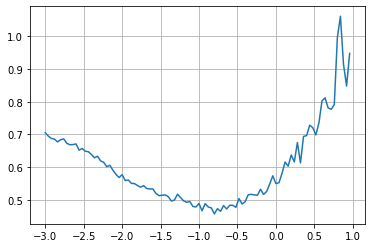

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(np.log10(history.history["lr"]), history.history["loss"])
plt.grid()

Based on the above chart let us pick the learning rate to be 1e-1

In [59]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(len(uniq_words),50,weights=[embedding_matrix],input_length = max_length,trainable=False))
model.add(tf.keras.layers.LSTM(7))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping('loss',1e-4,4,verbose=2)
history = model.fit(train_pad,np.array(train_label),epochs=300,callbacks=[callback])

Train on 4000 samples
Epoch 1/300
4000/4000 [==============================] - 3s 775us/sample - loss: 0.6932 - accuracy: 0.5303
Epoch 2/300
4000/4000 [==============================] - 1s 370us/sample - loss: 0.6837 - accuracy: 0.5675
Epoch 3/300
4000/4000 [==============================] - 2s 378us/sample - loss: 0.6804 - accuracy: 0.5660
Epoch 4/300
4000/4000 [==============================] - 1s 374us/sample - loss: 0.6768 - accuracy: 0.5832
Epoch 5/300
4000/4000 [==============================] - 2s 418us/sample - loss: 0.6754 - accuracy: 0.5903
Epoch 6/300
4000/4000 [==============================] - 1s 370us/sample - loss: 0.6710 - accuracy: 0.5907
Epoch 7/300
4000/4000 [==============================] - 2s 430us/sample - loss: 0.6628 - accuracy: 0.5945
Epoch 8/300
4000/4000 [==============================] - 1s 374us/sample - loss: 0.6492 - accuracy: 0.6120
Epoch 9/300
4000/4000 [==============================] - 2s 418us/sample - loss: 0.6357 - accuracy: 0.6435
Epoch 10/300
40

4000/4000 [==============================] - 1s 341us/sample - loss: 0.4104 - accuracy: 0.8140
Epoch 77/300
4000/4000 [==============================] - 1s 342us/sample - loss: 0.4143 - accuracy: 0.8190
Epoch 78/300
4000/4000 [==============================] - 1s 351us/sample - loss: 0.4053 - accuracy: 0.8192
Epoch 79/300
4000/4000 [==============================] - 1s 350us/sample - loss: 0.4047 - accuracy: 0.8170
Epoch 80/300
4000/4000 [==============================] - 1s 352us/sample - loss: 0.4020 - accuracy: 0.8210
Epoch 81/300
4000/4000 [==============================] - 2s 376us/sample - loss: 0.4062 - accuracy: 0.8173
Epoch 82/300
4000/4000 [==============================] - 1s 349us/sample - loss: 0.4013 - accuracy: 0.8213
Epoch 83/300
4000/4000 [==============================] - 1s 371us/sample - loss: 0.4048 - accuracy: 0.8160
Epoch 84/300
4000/4000 [==============================] - 1s 360us/sample - loss: 0.4064 - accuracy: 0.8142
Epoch 85/300
4000/4000 [=================

In [60]:
model.evaluate(test_pad,np.array(test_label),verbose=0)

[0.607633671760559, 0.7225]

Accuracy is 72.25 on test set, perhaps we can choose 100dimension word embeddings and try